In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

## Data Preprocessing

In [2]:
df = pd.read_csv('../data/voter_turnout_merged_all_states.csv')
print("shape: ",df.shape)
df.head()

shape:  (1492, 69)


,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,total_voters_college,total_voters_no_college,voted_voters_college,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122.0,23041.0,...,80668.0,27989.0,71356.0,22543.0,88.456389,80.542356,47.829424,331652,172221.0,CA
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122.0,14972.0,...,80668.0,27989.0,59248.0,17372.0,73.446720,62.067241,48.224196,331652,130249.0,CA
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122.0,16057.0,...,80668.0,27989.0,60766.0,18951.0,75.328507,67.708743,46.819512,331652,135633.0,CA
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122.0,8145.0,...,80668.0,27989.0,38216.0,10811.0,47.374424,38.625889,51.034918,331652,75153.0,CA
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780.0,9229.0,...,19051.0,10653.0,16014.0,8674.0,84.058580,81.423073,49.752550,70359,41879.0,CA


In [3]:
df.Residence_Addresses_City.nunique()

213

In [4]:

#replace all NAN for voted_voters and total_voters counts  with 0

for col in ['voted_voters_asian', 'voted_voters_black', 'voted_voters_hispanic', 'voted_voters_others', 'voted_voters_white']:
    df[col] = df[col].fillna(0)
#double check to make sure the sum adds up
print(sum(df['voted_voters'] != df['voted_voters_asian'] + 
          df['voted_voters_black']+df['voted_voters_hispanic'] + 
          df['voted_voters_others'] + df['voted_voters_white']))

for col in ['total_voters_asian', 'total_voters_black', 'total_voters_hispanic', 'total_voters_others', 'total_voters_white']:
    df[col] = df[col].fillna(0)
        
# voter_population is calculated from census data for people over age 20
# calculate new total_voters columns that should be used instead.
df['total_voters'] = df['total_voters_asian'] + df['total_voters_black']+df['total_voters_hispanic'] + df['total_voters_others'] + df['total_voters_white']
print(sum(df['total_voters'] !=  df['voter_population']))
print(df.shape)
df = df.drop(columns = ['voter_population'])
print(df.shape)

0
1492
(1492, 70)
(1492, 69)


In [5]:
df.columns.values

array(['Residence_Addresses_City', 'elec_date', 'elec_year', 'elec_type',
       'total_voters_asian', 'total_voters_black',
       'total_voters_hispanic', 'total_voters_others',
       'total_voters_white', 'voted_voters_asian', 'voted_voters_black',
       'voted_voters_hispanic', 'voted_voters_others',
       'voted_voters_white', 'perc_turnout_asian', 'perc_turnout_black',
       'perc_turnout_hispanic', 'perc_turnout_others',
       'perc_turnout_white', 'FECDonors_TotalDonationsAmount',
       'FECDonors_NumberOfDonations', 'mean_donation',
       'total_voters_$1000-14999', 'total_voters_$100000-124999',
       'total_voters_$125000-149999', 'total_voters_$15000-24999',
       'total_voters_$150000-174999', 'total_voters_$175000-199999',
       'total_voters_$200000-249999', 'total_voters_$25000-34999',
       'total_voters_$250000+', 'total_voters_$35000-49999',
       'total_voters_$50000-74999', 'total_voters_$75000-99999',
       'voted_voters_$1000-14999', 'voted_voters_$1

In [6]:
#specify columns to use. Don't want to use data that already has turnout information
# 'FECDonors_TotalDonationsAmount' can be removed since it can be computed using mean_donation and FECDonors_NumberOfDonations
use_cols = ['Residence_Addresses_City', 'state', 'elec_type', 
             'rcv', 'turnout']


In [7]:
#define RCV and non-rcv cities
rcv_cities = ['Albany', 'Berkeley', 'Eureka', 'Oakland', 'Palm Desert', 'San Francisco', 'San Leandro',
             'Las Cruces', 'Santa Fe', 'Boulder', 'Burlington', 'Portland', 'Takoma Park', 'Bluffdale',
             'Payson', 'Cottonwood Heights', 'Salt Lake City', 'Sandy', 'Midvale', 'Draper', 'Lehi',
             'Springville', 'South Salt Lake', 'Magna', 'Heber', 'Millcreek', 'Riverton', 'St. Louis Park',
             'Bloomington', 'Minneapolis', 'Minnetonka']
non_rcv_cities = list(set(df['Residence_Addresses_City']) - set(rcv_cities))

In [8]:
#function to generate rcv labels
def label_rcv(row):
    if row['Residence_Addresses_City'] in rcv_cities:
        return 1
    else:
        return 0

In [9]:
#add rcv label
df['rcv'] = df.apply(lambda row: label_rcv(row), axis=1)

#add turnout column
df['turnout'] = df['voted_voters'] / df['total_voters']

#filter to usable columns (i.e. columns that do not show turnout)
df = df[use_cols]
df.head()

,Residence_Addresses_City,state,elec_type,rcv,turnout
0,Oakland,CA,General,1,0.779281
1,Oakland,CA,General,1,0.589362
2,Oakland,CA,General,1,0.613724
3,Oakland,CA,General,1,0.340059
4,San Leandro,CA,General,1,0.767887


In [10]:
#checking rows with missing values
df.columns[df.isna().any()].tolist()

[]

In [11]:
#group by city and election type
df = df.groupby(['Residence_Addresses_City', 'elec_type','state'], as_index=False).mean()
# df.drop(columns=['Residence_Addresses_City'], inplace=True)

df.head()


,Residence_Addresses_City,elec_type,state,rcv,turnout
0,Adelphi,General,MD,0.0,0.455109
1,Alamogordo,General,NM,0.0,0.491373
2,Alamogordo,Local_or_Municipal,NM,0.0,0.114373
3,Alamosa,Consolidated_General,CO,0.0,0.348872
4,Alamosa,General,CO,0.0,0.596245


In [12]:
#examine data
print(df.shape)
df.describe()

(369, 5)


,rcv,turnout
count,369.000000,369.000000
mean,0.151762,0.428963
std,0.359277,0.200257
min,0.000000,0.065370
25%,0.000000,0.233794
50%,0.000000,0.482363
75%,0.000000,0.601007
max,1.000000,0.756453


In [13]:
print(df.columns[df.isna().any()].tolist())

[]


In [14]:
df['rcv'].sum()

56.0

# Census Data

In [15]:
cities = pd.read_csv('../data/cities.csv', usecols=['state_id', 'RCV', 'city_ascii',  
                                                   'population_proper',
                                                    'race_white', 
                                                    'education_college_or_above',
                                                    'age_median', 
                                                    'income_household_median'])
print(cities.state_id.unique())

CA_cities = pd.read_csv('../data/ca-cities.csv', usecols=['state_id', 'RCV', 'city_ascii', 
                                                          'race_white', 
                                                          'population_proper',
                                                          'education_college_or_above',
                                                          'age_median', 
                                                          'income_household_median'])

cities = pd.concat([cities, CA_cities])
cities = cities.rename(columns = {'RCV': 'rcv', 'city_ascii': 'Residence_Addresses_City',
                                 'state_id': 'state'})
cities['rcv'] = cities['rcv'].fillna(0)

cities.head()



['NM' 'CO' 'VT' 'ME' 'MD' 'UT' 'MN']


,rcv,Residence_Addresses_City,state,population_proper,age_median,income_household_median,education_college_or_above,race_white
0,0.0,Los Alamos,NM,12035,41.7,101399,66.5,84.4
1,0.0,Albuquerque,NM,558545,36.2,49878,34.3,73.6
2,0.0,Rio Rancho,NM,96159,38.1,63180,30.2,79.9
3,0.0,Farmington,NM,45450,32.9,55179,20.2,61.1
4,0.0,North Valley,NM,11999,48.1,50236,28.0,74.9


In [16]:
cities.describe()

,rcv,population_proper,age_median,income_household_median,education_college_or_above,race_white
count,913.000000,9.130000e+02,913.000000,913.000000,913.000000,913.000000
mean,0.033954,5.636355e+04,36.791566,73569.914567,33.390361,68.947426
std,0.181210,1.596584e+05,6.038693,29671.599317,18.023748,21.930579
min,0.000000,3.564000e+03,19.200000,23541.000000,1.800000,3.500000
25%,0.000000,1.548200e+04,33.000000,52136.000000,19.200000,56.100000
50%,0.000000,2.640500e+04,36.600000,67614.000000,31.300000,74.900000
75%,0.000000,5.876600e+04,40.500000,89446.000000,45.000000,86.700000
max,1.000000,3.999759e+06,75.300000,238750.000000,95.300000,98.700000


In [17]:
print(cities.columns)
print(cities.shape)


Index(['rcv', 'Residence_Addresses_City', 'state', 'population_proper',
       'age_median', 'income_household_median', 'education_college_or_above',
       'race_white'],
      dtype='object')
(913, 8)


In [18]:
selected_df = df[['rcv', 
                  'state', 
                  'Residence_Addresses_City', 
                  'elec_type',
                  'turnout']]
print(selected_df.shape)
print(selected_df.Residence_Addresses_City.nunique())

selected_df = selected_df.merge(cities, 
                     on = ['Residence_Addresses_City', 'rcv', 'state'], how = 'left')
print(selected_df.shape)
print(selected_df.Residence_Addresses_City.nunique())


(369, 5)
213
(369, 10)
213


In [19]:
selected_df.head()

,rcv,state,Residence_Addresses_City,elec_type,turnout,population_proper,age_median,income_household_median,education_college_or_above,race_white
0,0.0,MD,Adelphi,General,0.455109,15898,33.9,68064,32.3,17.2
1,0.0,NM,Alamogordo,General,0.491373,31248,37.0,45531,20.1,79.1
2,0.0,NM,Alamogordo,Local_or_Municipal,0.114373,31248,37.0,45531,20.1,79.1
3,0.0,CO,Alamosa,Consolidated_General,0.348872,9871,27.3,32785,25.3,83.4
4,0.0,CO,Alamosa,General,0.596245,9871,27.3,32785,25.3,83.4


In [20]:
#one-hot encode categorical cols
cat_cols = ['elec_type', 'state']

selected_df = pd.get_dummies(data=selected_df, columns=cat_cols)
print(selected_df.shape)
selected_df.head()


(369, 19)


,rcv,Residence_Addresses_City,turnout,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.455109,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.491373,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.114373,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.348872,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.596245,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


## Model Implementation

In [21]:
# split the data in 80:20 for train:test dataset
train_size=0.8

X = selected_df.drop(columns=['turnout','Residence_Addresses_City'])
y = df['turnout']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(295, 17)
(295,)
(74, 17)
(74,)


(None, None)

# Random Forest

In [22]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#implement random forest
rf = RandomForestRegressor()

# n_estimators (The number of trees in the forest) default is 100, set 10, 20, 30 
# max_features: “auto”=n_features, “sqrt” =sqrt(n_features), “log2”=log2(n_features)

tuned_parameters = {'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 3], 'max_features': [4, 8, 16, 20, 24]}
    
clf = GridSearchCV(RandomForestRegressor(bootstrap = True, random_state = 0), 
                   tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)

clf.score(X_train, y_train)
best_params = clf.best_params_ 
best_params

Fitting 5 folds for each of 45 candidates, totalling 225 fits


{'max_depth': None, 'max_features': 8, 'n_estimators': 100}

In [23]:
best_model = RandomForestRegressor(bootstrap = True, random_state = 0, max_depth= None, max_features= 8, n_estimators = 100)

best_model.fit(X_train, y_train)

train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

def get_metrics(target, prediction):

    # Mean absolute error (MAE)
    mae = mean_absolute_error(target.values.ravel(), prediction)

    # Mean squared error (MSE)
    mse = mean_squared_error(target.values.ravel(), prediction)

    # R-squared scores
    r2 = r2_score(target.values.ravel(), prediction)

    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('R-squared scores:', round(r2, 3))
    return pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])
    
print("Train")
rf_overall_train = get_metrics(y_train, train_pred)
rf_overall_train.columns = ['metric', 'rf_overall_train']

print("Test")
rf_overall_test = get_metrics(y_test, test_pred)
rf_overall_test.columns = ['metric', 'rf_overall_test']

Train
Mean Absolute Error: 0.013
Mean Squared Error: 0.0
R-squared scores: 0.993
Test
Mean Absolute Error: 0.049
Mean Squared Error: 0.005
R-squared scores: 0.864


In [24]:
#function to generate and print ordered list of feature importance scores
def ordered_feature_importance(features, feature_importances, n=10):
    features = list(features)
    feature_importance = list(feature_importances)
    
    zipped = zip(features, feature_importance)
    sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
    
    unzipped = list(zip(*sorted_zipped))
    sorted_features = list(unzipped[0])
    sorted_feature_importance = list(unzipped[1])

    for i in range(n):
        print('Feature {} ({}) importance: {}'.format(i, sorted_features[i], sorted_feature_importance[i]))
    
    return sorted_features, sorted_feature_importance
sorted_features, sorted_feature_importance = ordered_feature_importance(X.columns, best_model.feature_importances_, n=len(X.columns))


Feature 0 (elec_type_General) importance: 0.5471932652676152
Feature 1 (elec_type_Consolidated_General) importance: 0.15785709218840255
Feature 2 (elec_type_Local_or_Municipal) importance: 0.09822311608785995
Feature 3 (education_college_or_above) importance: 0.04127881692339575
Feature 4 (state_CO) importance: 0.031019638554478646
Feature 5 (age_median) importance: 0.027299796566399203
Feature 6 (race_white) importance: 0.026187779861562722
Feature 7 (state_MN) importance: 0.018332233411091615
Feature 8 (state_NM) importance: 0.015488118197032068
Feature 9 (income_household_median) importance: 0.014495869508855033
Feature 10 (population_proper) importance: 0.009887685884281718
Feature 11 (state_CA) importance: 0.003387763025790855
Feature 12 (state_VT) importance: 0.0033799828645549425
Feature 13 (state_UT) importance: 0.0029516675341794475
Feature 14 (state_ME) importance: 0.0012490895631744438
Feature 15 (rcv) importance: 0.0009783383202801913
Feature 16 (state_MD) importance: 0.000

In [25]:
# #plot feature importance
# plt.bar(np.arange(len(sorted_feature_importance)), sorted_feature_importance)
# plt.xticks(rotation = 0) 
# plt.title('Random Forest Feature Importance')
# plt.ylabel('Feature importance')
# plt.xlabel('Ordered feature number')

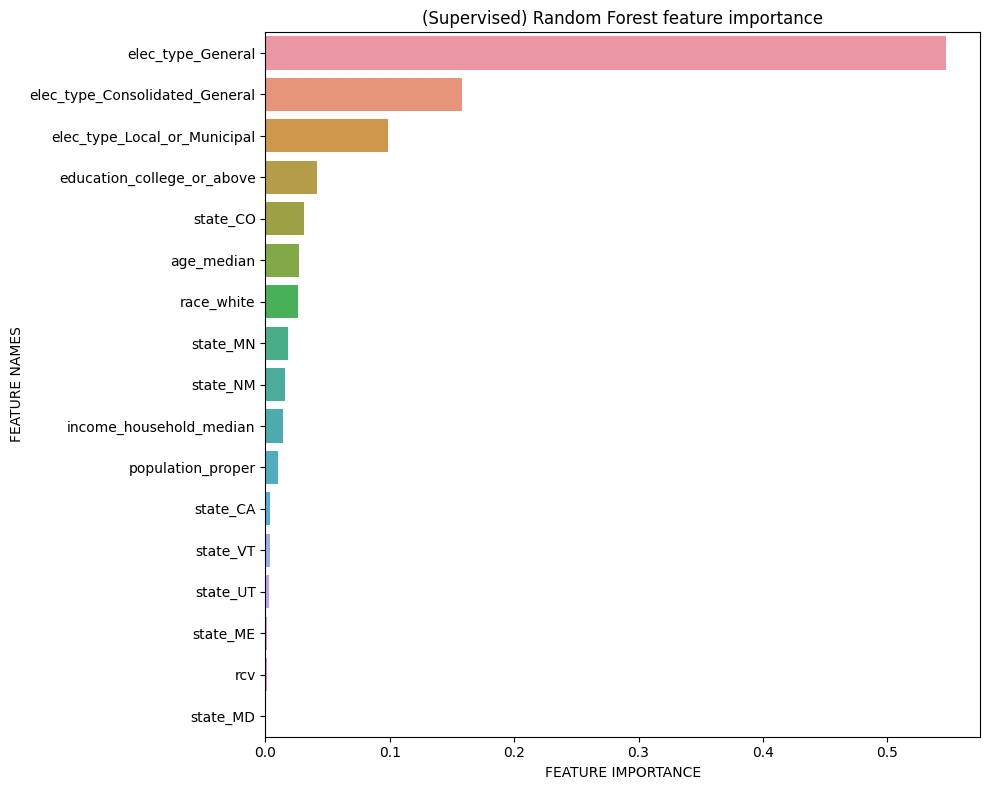

In [26]:
import seaborn as sns 
def plot_feature_importance(importance,names,fig_title, file_name):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(fig_title)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.tight_layout()
    plt.savefig(f'../data/plots/{file_name}.jpg')

plot_feature_importance(best_model.feature_importances_, X.columns,
                        fig_title = '(Supervised) Random Forest feature importance', 
                        file_name = 'RF_feature_imp_supervised_overall')


# How does feature importance differ between RCV and Non RCV?

### RCV

In [27]:
#implement random forest

rcv_df = selected_df[selected_df['rcv'] == 1]
rcv_target = rcv_df['turnout']
rcv_data = rcv_df.drop(columns=['turnout', 'rcv','Residence_Addresses_City'])

rcv_rf = RandomForestRegressor(bootstrap = True, oob_score = True, random_state = 0, 
                               max_depth= None, max_features= 8, n_estimators = 100)
rcv_rf.fit(rcv_data, rcv_target)

rcv_pred = rcv_rf.predict(rcv_data)

def get_metrics_CV(model, data, target):
    mae = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)), 3)
    mse = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_squared_error', cv=10, n_jobs=-1)), 3)
    r2 = round(np.mean(cross_val_score(model, data, target, 
                                  scoring='r2', cv=10, n_jobs=-1)), 3)
    
    
    print("Cross validation Mean Absolute Error score:", mae)
    print("Cross validation Mean Squared Error score:", mse)
    print("Cross validation R-sqaured score:", r2)
    return pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])

print("RCV Cross Validation")
rf_rcv_cv = get_metrics_CV(rcv_rf, rcv_data, rcv_target)
rf_rcv_cv.columns = ['metric', 'rf_rcv_cv']
print(rf_rcv_cv)


RCV Cross Validation
Cross validation Mean Absolute Error score: 0.049
Cross validation Mean Squared Error score: 0.004
Cross validation R-sqaured score: 0.872
                metric  rf_rcv_cv
0  Mean_Absolute_Error      0.049
1   Mean_Squared_Error      0.004
2      R_squared_score      0.872


In [28]:
#generate and print ordered list of feature importance scores
rcv_sorted_features, rcv_sorted_feature_importance = ordered_feature_importance(rcv_data.columns, rcv_rf.feature_importances_, n=len(rcv_data.columns))

Feature 0 (elec_type_General) importance: 0.5808610979692791
Feature 1 (elec_type_Consolidated_General) importance: 0.22657890773787528
Feature 2 (elec_type_Local_or_Municipal) importance: 0.03343608396445203
Feature 3 (income_household_median) importance: 0.03268662346490326
Feature 4 (education_college_or_above) importance: 0.031838327054482626
Feature 5 (age_median) importance: 0.026176852489906657
Feature 6 (race_white) importance: 0.016727470140386416
Feature 7 (population_proper) importance: 0.016699982422520503
Feature 8 (state_MN) importance: 0.013364523915457428
Feature 9 (state_CO) importance: 0.006977443285605377
Feature 10 (state_NM) importance: 0.005893678476034714
Feature 11 (state_VT) importance: 0.0028120547418765134
Feature 12 (state_UT) importance: 0.002807936590346469
Feature 13 (state_CA) importance: 0.0021046681506911025
Feature 14 (state_MD) importance: 0.0007558279020445959
Feature 15 (state_ME) importance: 0.0002785216941378713


In [29]:
# #plot feature importance
# plt.bar(np.arange(len(rcv_sorted_features)), rcv_sorted_feature_importance)
# plt.title('Random Forest Feature Importance')
# plt.ylabel('Feature importance')
# plt.xlabel('Ordered feature number')

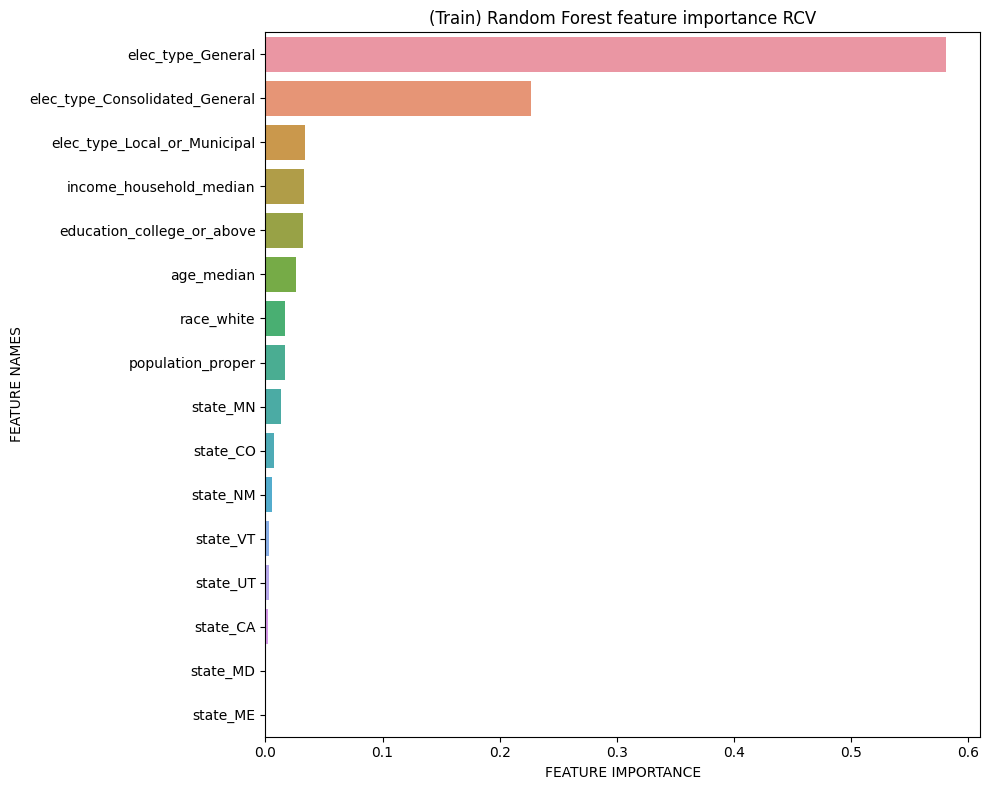

In [30]:
plot_feature_importance(rcv_rf.feature_importances_, rcv_data.columns, 
                        fig_title ='(Train) Random Forest feature importance RCV', 
                        file_name = 'RF_feature_imp_RCV')

### Non-RCV

In [31]:
#implement random forest
non_rcv_df = selected_df[selected_df['rcv'] == 0]
non_rcv_target = non_rcv_df['turnout']
non_rcv_data = non_rcv_df.drop(columns=['turnout', 'rcv','Residence_Addresses_City'])

non_rcv_rf = RandomForestRegressor(bootstrap = True, random_state = 0, oob_score = True,
                                   max_depth= None, max_features= 16, n_estimators = 100)
non_rcv_rf.fit(non_rcv_data, non_rcv_target)


non_rcv_pred = non_rcv_rf.predict(non_rcv_data)

print("Non RCV Cross Validation")
rf_nonrcv_cv = get_metrics_CV(non_rcv_rf, non_rcv_data, non_rcv_target)
rf_nonrcv_cv.columns = ['metric', 'rf_nonrcv_cv']
print(rf_nonrcv_cv)


Non RCV Cross Validation
Cross validation Mean Absolute Error score: 0.041
Cross validation Mean Squared Error score: 0.003
Cross validation R-sqaured score: 0.923
                metric  rf_nonrcv_cv
0  Mean_Absolute_Error         0.041
1   Mean_Squared_Error         0.003
2      R_squared_score         0.923


In [32]:
#generate and print ordered list of feature importance scores
non_rcv_sorted_features, non_rcv_sorted_feature_importance = ordered_feature_importance(non_rcv_data.columns, non_rcv_rf.feature_importances_, n=len(non_rcv_data.columns))

Feature 0 (elec_type_General) importance: 0.7728655516014658
Feature 1 (education_college_or_above) importance: 0.056682334390019844
Feature 2 (state_CO) importance: 0.05381906623547182
Feature 3 (race_white) importance: 0.03875268736042662
Feature 4 (age_median) importance: 0.027904664424025026
Feature 5 (state_MN) importance: 0.013367554056222277
Feature 6 (income_household_median) importance: 0.011024022839873764
Feature 7 (population_proper) importance: 0.008330204043729415
Feature 8 (state_NM) importance: 0.0061808792648662975
Feature 9 (state_UT) importance: 0.0032768784685993733
Feature 10 (elec_type_Consolidated_General) importance: 0.001999217721465802
Feature 11 (elec_type_Local_or_Municipal) importance: 0.0018577759392661775
Feature 12 (state_VT) importance: 0.0016682307854233862
Feature 13 (state_ME) importance: 0.0008299252186719402
Feature 14 (state_MD) importance: 0.0007793403920717656
Feature 15 (state_CA) importance: 0.0006616672584008139


In [33]:
# #plot feature importance
# plt.bar(np.arange(len(non_rcv_sorted_features)), non_rcv_sorted_feature_importance)
# plt.title('Random Forest Feature Importance')
# plt.ylabel('Feature importance')
# plt.xlabel('Ordered feature number')

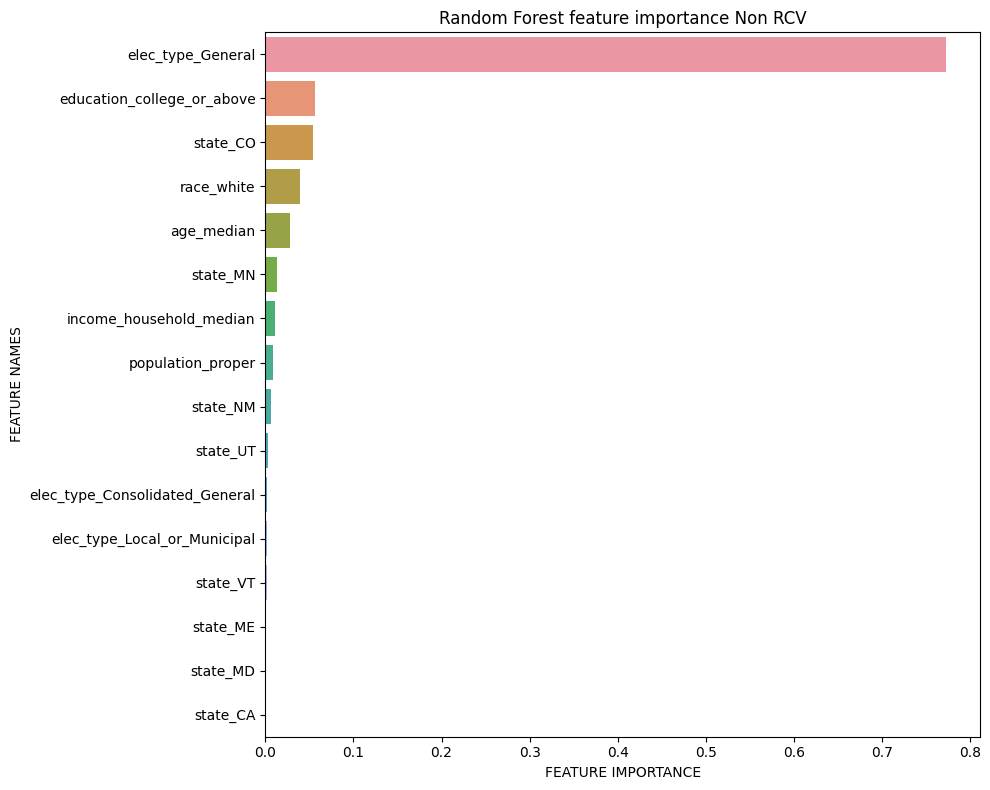

In [34]:
plot_feature_importance(non_rcv_rf.feature_importances_, non_rcv_data.columns, 
                        fig_title = 'Random Forest feature importance Non RCV', 
                        file_name = 'RF_feature_imp_Non_RCV')


### RCV vs. Non-RCV

In [35]:
#Match ranking of feature importance
rcv_v_nonrcv_df = pd.DataFrame({'rcv_feature': rcv_sorted_features, 'rcv_importance': rcv_sorted_feature_importance,
                  'non_rcv_feature': non_rcv_sorted_features, 'non_rcv_importance': non_rcv_sorted_feature_importance})
rcv_v_nonrcv_df

,rcv_feature,rcv_importance,non_rcv_feature,non_rcv_importance
0,elec_type_General,0.580861,elec_type_General,0.772866
1,elec_type_Consolidated_General,0.226579,education_college_or_above,0.056682
2,elec_type_Local_or_Municipal,0.033436,state_CO,0.053819
3,income_household_median,0.032687,race_white,0.038753
4,education_college_or_above,0.031838,age_median,0.027905
5,age_median,0.026177,state_MN,0.013368
6,race_white,0.016727,income_household_median,0.011024
7,population_proper,0.016700,population_proper,0.008330
8,state_MN,0.013365,state_NM,0.006181
9,state_CO,0.006977,state_UT,0.003277


In [36]:
#Match features
nonrcv_df = pd.DataFrame({'feature': non_rcv_sorted_features, 'importance_nonrcv': non_rcv_sorted_feature_importance})
rcv_df = pd.DataFrame({'feature': rcv_sorted_features, 'importance_rcv': rcv_sorted_feature_importance})
rcv_v_nonrcv_df = nonrcv_df.merge(rcv_df, on = "feature")
rcv_v_nonrcv_df.head()

,feature,importance_nonrcv,importance_rcv
0,elec_type_General,0.772866,0.580861
1,education_college_or_above,0.056682,0.031838
2,state_CO,0.053819,0.006977
3,race_white,0.038753,0.016727
4,age_median,0.027905,0.026177


In [37]:
rcv_v_nonrcv_df = pd.melt(rcv_v_nonrcv_df, id_vars=['feature'], value_vars=['importance_nonrcv','importance_rcv'])
rcv_v_nonrcv_df.head()

,feature,variable,value
0,elec_type_General,importance_nonrcv,0.772866
1,education_college_or_above,importance_nonrcv,0.056682
2,state_CO,importance_nonrcv,0.053819
3,race_white,importance_nonrcv,0.038753
4,age_median,importance_nonrcv,0.027905


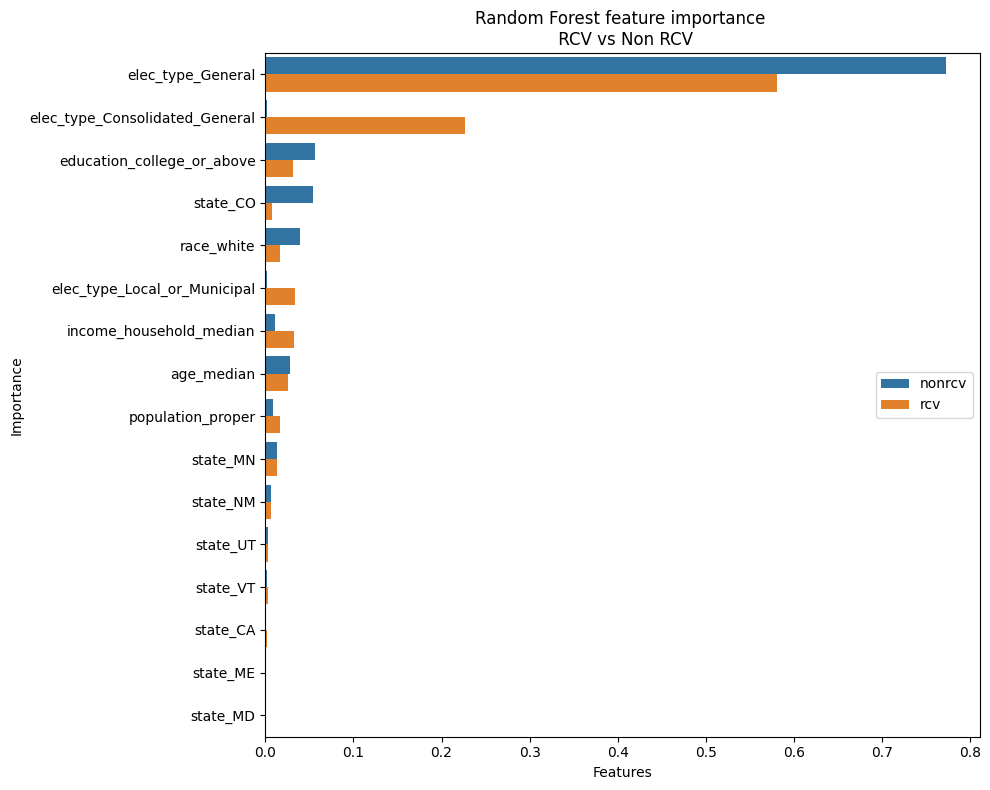

In [38]:
# Plotting
import seaborn as sns 

#Create arrays from feature importance and feature names
variable = np.array(rcv_v_nonrcv_df['variable'])
value = np.array(rcv_v_nonrcv_df['value'])
feature_names = np.array(rcv_v_nonrcv_df['feature'])

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'variable':variable,'value':value}
fi_df = pd.DataFrame(data)
fi_df = fi_df.replace({'importance_nonrcv': 'nonrcv', 'importance_rcv': 'rcv'})

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['value'], ascending=False,inplace=True)

plt.figure(figsize=(10,8))
palette ={"nonrcv": "C0", "rcv": "C1"}

sns.barplot(x=fi_df['value'], y=fi_df['feature_names'], hue = fi_df['variable'], palette=palette)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest feature importance \n RCV vs Non RCV')
plt.legend(loc='center right')
plt.tight_layout()
plt.savefig(f'../data/plots/RF_feature_imp_RCV_vs_Non_RCV.jpg')


# Linear Regression

In [39]:
# importing modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [40]:
num_cols = ['population_proper', 'age_median', 'income_household_median', 'education_college_or_above', 'race_white']

ct = ColumnTransformer([
        ('somename', StandardScaler(), num_cols)
    ], remainder='passthrough')

ct.fit(X_train)
scaled_X_train = pd.DataFrame(ct.transform(X_train), columns = X_train.columns)

scaled_X_test = pd.DataFrame(ct.transform(X_test), columns = X_test.columns)
scaled_X_train.head()


,rcv,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,-0.126752,-0.054608,0.217799,1.356231,0.063835,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.417599,1.430199,-0.926426,0.300222,0.683112,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.358968,-0.469715,-0.697429,-0.935111,0.709747,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.424485,0.839469,0.324136,-0.755788,0.949467,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.348161,-0.629372,-0.181940,1.296457,0.583228,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
#implement random forest
linreg = LinearRegression()

linreg.fit(scaled_X_train, y_train)
train_pred = linreg.predict(scaled_X_train)
test_pred = linreg.predict(scaled_X_test)


print("Train")
linreg_overall_train = get_metrics(y_train, train_pred)
linreg_overall_train.columns = ['metric', 'linreg_overall_train']
print(linreg_overall_train)

print("Test")
linreg_overall_test = get_metrics(y_test, test_pred)
linreg_overall_test.columns = ['metric', 'linreg_overall_test']
print(linreg_overall_test)

Train
Mean Absolute Error: 0.044
Mean Squared Error: 0.003
R-squared scores: 0.923
                metric  linreg_overall_train
0  Mean_Absolute_Error              0.044052
1   Mean_Squared_Error              0.003151
2      R_squared_score              0.922999
Test
Mean Absolute Error: 0.055
Mean Squared Error: 0.006
R-squared scores: 0.827
                metric  linreg_overall_test
0  Mean_Absolute_Error             0.054979
1   Mean_Squared_Error             0.005828
2      R_squared_score             0.826848


In [42]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(linreg.coef_))], axis = 1)
coefficients.columns = ['feature', 'linreg_coefficient']

coefficients.sort_values('linreg_coefficient', ascending = False)

,feature,linreg_coefficient
7,elec_type_General,0.250455
10,state_CO,0.081565
13,state_MN,0.056022
1,population_proper,0.026331
15,state_UT,0.026258
3,income_household_median,0.022029
4,education_college_or_above,0.018512
5,race_white,0.009226
0,rcv,0.003373
2,age_median,-0.004454


# Compare Random Forest and Linear Regression

In [43]:
pd.merge(linreg_overall_train, rf_overall_train, on = "metric")


,metric,linreg_overall_train,rf_overall_train
0,Mean_Absolute_Error,0.044052,0.013411
1,Mean_Squared_Error,0.003151,0.000291
2,R_squared_score,0.922999,0.992899


In [44]:
pd.merge(linreg_overall_test, rf_overall_test, on = "metric")


,metric,linreg_overall_test,rf_overall_test
0,Mean_Absolute_Error,0.054979,0.049424
1,Mean_Squared_Error,0.005828,0.004565
2,R_squared_score,0.826848,0.864373


# P-value from Linear Regression Model

In [45]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                turnout   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     223.0
Date:                Mon, 21 Nov 2022   Prob (F-statistic):          1.53e-145
Time:                        15:19:53   Log-Likelihood:                 431.03
No. Observations:                 295   AIC:                            -830.1
Df Residuals:                     279   BIC:                            -771.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       